# Testing out a counter-based bootstrap
Instead of an element per occurrence, can we use values and number of occurrences per value to speed up this process?

## Testing on dummy data

In [1]:
import numpy as np

from collections import Counter

In [2]:
# list of numbers, for example, the different values of journey length
Y = [7,9,8,25,11,26,7,9,8]

In [3]:
boot_reps = 4000

In [20]:
# bayesian_bootstrap fn https://github.com/lmc2179/bayesian_bootstrap/blob/master/bayesian_bootstrap/bootstrap.py
def mean_bb(X, n_replications):
    """Simulate the posterior distribution of the mean.
    Parameter X: The observed data (array like)
    Parameter n_replications: The number of bootstrap replications to perform (positive integer)
    Returns: Samples from the posterior
    """
    samples = []
    weights = np.random.dirichlet([1]*len(X), n_replications)
    for w in weights:
        samples.append(np.dot(X, w))
    return samples

In [6]:
samples = []
weights = np.random.dirichlet([1]*len(Y), boot_reps)
weights

array([[0.03237257, 0.1061762 , 0.02516559, ..., 0.16463726, 0.17605893,
        0.2998557 ],
       [0.07348467, 0.02280695, 0.0743896 , ..., 0.15561783, 0.08690552,
        0.33336323],
       [0.12733391, 0.03897725, 0.12102781, ..., 0.02079075, 0.42946135,
        0.04036476],
       ...,
       [0.13782901, 0.33588651, 0.00095084, ..., 0.20534844, 0.07543616,
        0.13614675],
       [0.10617225, 0.37424176, 0.13101396, ..., 0.02663349, 0.2483882 ,
        0.00412601],
       [0.17886845, 0.10698402, 0.32436949, ..., 0.0460063 , 0.06795785,
        0.06392503]])

In [7]:
# A Counter is a dict subclass for counting hashable objects. It is an
# unordered collection where elements are stored as dictionary keys and their
# counts are stored as dictionary values. Counts are allowed to be any integer
# value including zero or negative counts. The Counter class is similar to
# bags or multisets in other languages.
counter_Y = Counter(Y)

In [8]:
%timeit [val for val in counter_Y.values()]

487 ns ± 7.78 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [9]:
%timeit list(counter_Y.values())

355 ns ± 4.75 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [36]:
def mean_ss(counter_X_keys, counter_X_vals, n_replications):
    """Simulate the posterior distribution of the mean.
    Parameter X: The observed data (array like)
    Parameter n_replications: The number of bootstrap replications to perform (positive integer)
    Returns: Samples from the posterior
    """
    samples = []
    weights = np.random.dirichlet(counter_X_vals, n_replications)
    for w in weights:
        samples.append(np.dot(counter_X_keys, w))
    return samples

In [38]:
counter_Y_keys = list(counter_Y.keys())
counter_Y_vals = list(counter_Y.values())

In [41]:
%timeit np.mean(mean_ss(counter_Y_keys, counter_Y_vals, 10000))

26.2 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%timeit np.mean(mean_bb(Y, 10000))

29.1 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Testing on A/B test 1

In [48]:
import os 
import pandas as pd
import ast
import re

# bayesian bootstrap and vis
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext

# progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate progress bar goodness
tqdm.pandas(tqdm_notebook)

pd.set_option('max_colwidth',500)


In [64]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "taxon_ab_2019-02-14.csv.gz"
filepath = os.path.join(
    DATA_DIR, "sampled_journey",
    filename)
filepath

'/Users/suganyasivaskantharajah/code/govuk_ab_analysis/data/sampled_journey/taxon_ab_2019-02-14.csv.gz'

In [65]:
# read in processed sampled journey with just the cols we need for related links
df = pd.read_csv(filepath, sep ="\t", compression="gzip")
# convert from str to list
df['Event_cat_act_agg']= df['Event_cat_act_agg'].progress_apply(ast.literal_eval)
df['Page_Event_List'] = df['Page_Event_List'].progress_apply(ast.literal_eval)
df['Page_List'] = df['Page_List'].progress_apply(ast.literal_eval)

100%|██████████| 202770/202770 [00:05<00:00, 40200.64it/s]


In [66]:
df['Page_List_Length'] = df['Page_List'].progress_apply(len)

100%|██████████| 202770/202770 [00:00<00:00, 678882.07it/s]


In [67]:
# drop dodgy rows, where page variant is not A or B. 
df = df.query('ABVariant in ["A", "B"]')

In [68]:
df.shape

(202770, 6)

In [57]:
# df = df.head(10000)

In [69]:
a_len = np.repeat(df[df.ABVariant == "A"].Page_List_Length, df[df.ABVariant == "A"].Occurrences)
a_len.values

b_len = np.repeat(df[df.ABVariant == "B"].Page_List_Length, df[df.ABVariant == "B"].Occurrences)
b_len.values

array([10,  0,  1, ...,  3,  1,  3])

In [70]:
with NumpyRNGContext(1337):
    a_bootstrap = bb.mean(a_len.values, n_replications=boot_reps)
    b_bootstrap = bb.mean(b_len.values, n_replications=boot_reps)

In [73]:
grouped_by_length =  df.groupby('Page_List_Length').sum().reset_index()

In [84]:
with NumpyRNGContext(1337):
    A_grouped_by_length =  df[df.ABVariant == "A"].groupby(
        'Page_List_Length').sum().reset_index()
    B_grouped_by_length =  df[df.ABVariant == "B"].groupby(
        'Page_List_Length').sum().reset_index()
    a_bootstrap_ss = mean_ss(A_grouped_by_length['Page_List_Length'], 
        A_grouped_by_length['Occurrences'], 
        boot_reps)
    b_bootstrap_ss = mean_ss(B_grouped_by_length['Page_List_Length'], 
        B_grouped_by_length['Occurrences'], 
        boot_reps)


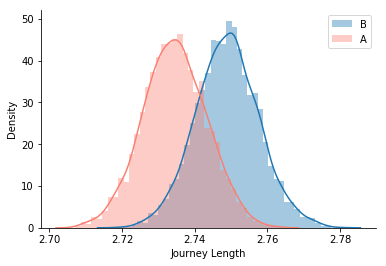

In [85]:
ax = sns.distplot(b_bootstrap, label='B')
ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
plt.legend(facecolor='white');

In [87]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.7168695286412095 
high ci: 2.7511399643542775
low ci: 2.731517818586557 
high ci: 2.766280584795612


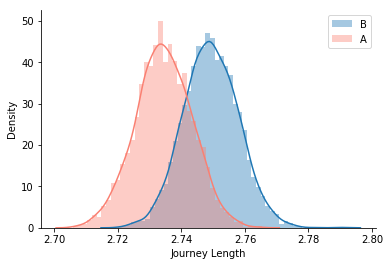

In [86]:
ax = sns.distplot(b_bootstrap_ss, label='B')
ax = sns.distplot(a_bootstrap_ss, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
plt.legend(facecolor='white');

In [88]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap_ss)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap_ss)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.7166774394424515 
high ci: 2.7515641802213637
low ci: 2.731881533862873 
high ci: 2.7658374940180686


In [89]:
%%timeit 
with NumpyRNGContext(1337):
    a_bootstrap = bb.mean(a_len.values, n_replications=boot_reps)
    b_bootstrap = bb.mean(b_len.values, n_replications=boot_reps)\
    
# 1min 10s ± 3.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

1min 10s ± 3.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%%timeit
with NumpyRNGContext(1337):
    A_grouped_by_length =  df[df.ABVariant == "A"].groupby(
        'Page_List_Length').sum().reset_index()
    B_grouped_by_length =  df[df.ABVariant == "B"].groupby(
        'Page_List_Length').sum().reset_index()
    a_bootstrap_ss = mean_ss(A_grouped_by_length['Page_List_Length'], 
        A_grouped_by_length['Occurrences'], 
        boot_reps)
    b_bootstrap_ss = mean_ss(B_grouped_by_length['Page_List_Length'], 
        B_grouped_by_length['Occurrences'], 
        boot_reps)

# 593 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

593 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
